In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

In [2]:
import warnings
warnings.filterwarnings("ignore")
import scanpy.api as sc
from scanpy.neighbors import Neighbors
import scanorama

# Evaluating Alignment Score For Batch Correction

This notebook evaluates an "alignment score" to quantify the effects of batch correction. This notebook uses this metric to measure the performance of the Scanorama algorithm on two batches of Olivier's CAOV3 data with one batch receiving an addition of random gaussian noise.

# Load Data

In [3]:
SENS03_B1 = sc.read_10x_mtx("../data/Harismendy_data/170206/SENS03", var_names="gene_symbols")
SENS03_B2 = sc.read_10x_mtx("../data/Harismendy_data/170315/SENS03", var_names="gene_symbols")

## Downsample For Performance

In [4]:
def downsample_anndata(ad, n):
    rand_obs = np.random.choice(list(ad.obs.index), size=n, replace=False)
    return ad[rand_obs,:]

In [5]:
SENS03_B1 = downsample_anndata(SENS03_B1, 800)
SENS03_B2 = downsample_anndata(SENS03_B2, 800)

In [6]:
SENS03_B1.shape

(800, 33694)

In [7]:
SENS03_B2.shape

(800, 33694)

# Implement Alignment Score

In [8]:
INPUT_ANNS = [SENS03_B1, SENS03_B2]

In [9]:
min_cells = min(list(map(lambda x: x.n_obs, INPUT_ANNS)))
DS_ANNS = list(map(lambda x: downsample_anndata(x, min_cells), INPUT_ANNS))

## Merge Experiments

In [10]:
COMB_ANN = DS_ANNS[0].concatenate(DS_ANNS[1:], index_unique="_")
COMB_ANN.shape

(1600, 33694)

## Find Closest 1% Neighbors For All Cells

In [11]:
n_batch = len(INPUT_ANNS)

In [12]:
n_neighbors = max(int(0.01*min_cells), 10)
n_neighbors

10

In [13]:
sc.pp.neighbors(COMB_ANN, n_neighbors=22, knn=True)

         Falling back to preprocessing with `sc.pp.pca` and default params.


## Calculate Alignment Score

In [14]:
rows, cols = COMB_ANN.uns['neighbors']['distances'].nonzero()

In [15]:
def get_batch(i, adata):
    """
    Returns the batch number of a cell at index i in adata
    """
    return int(adata.obs.index[i].split('_')[1])

In [16]:
neighbor_counts = {}  #{cell_id: #same_batch}

for x, y in zip(rows, cols):
    try:
        neighbor_counts[x]
    except KeyError:
        neighbor_counts[x] = 0
    cell_batch = get_batch(x, COMB_ANN)
    neigh_batch = get_batch(y, COMB_ANN)
    if cell_batch == neigh_batch:
        neighbor_counts[x] += 1

In [17]:
(np.mean(list(neighbor_counts.values()))/n_neighbors)*n_batch

2.1592500000000001

# Summary Implementation Function

This cell defines a single function to run the above analysis given a list of AnnData

In [18]:
def downsample_anndata(ad, n):
    rand_obs = np.random.choice(list(ad.obs.index), size=n, replace=False)
    return ad[rand_obs,:]

def get_batch(i, adata):
    """
    Returns the batch number of a cell at index i in adata
    """
    return int(adata.obs.index[i].split('_')[1])

def score_batch_corr(anns, n_neighbors):
    min_cells = min(list(map(lambda x: x.n_obs, anns)))
    ds_anns = list(map(lambda x: downsample_anndata(x, min_cells), anns))
    comb_ann = ds_anns[0].concatenate(ds_anns[1:], index_unique="_")
    sc.tl.pca(comb_ann)
    sc.pp.neighbors(comb_ann, n_neighbors=n_neighbors, knn=True)
    rows, cols = comb_ann.uns['neighbors']['distances'].nonzero()
    neighbor_counts = {}  #{cell_id: #same_batch}
    for x, y in zip(rows, cols):
        try:
            neighbor_counts[x]
        except KeyError:
            neighbor_counts[x] = 0
        cell_batch = get_batch(x, comb_ann)
        neigh_batch = get_batch(y, comb_ann)
        if cell_batch != neigh_batch:
            neighbor_counts[x] += 1
    sc.pl.pca(comb_ann, color='batch', show=True, save=False)
    return (np.mean(list(neighbor_counts.values()))/n_neighbors)*len(anns)

In [19]:
N_NEIGHBORS = int(0.01*SENS03_B1.shape[0])
N_NEIGHBORS = 10

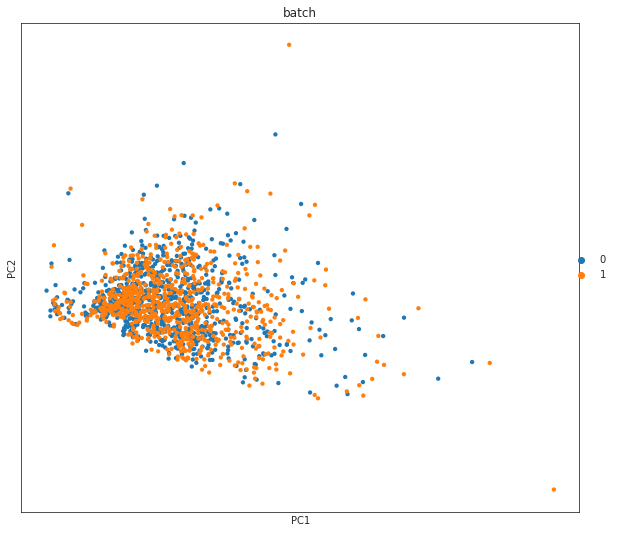

0.89512499999999995

In [20]:
score_batch_corr([SENS03_B1, SENS03_B2], N_NEIGHBORS)

# Add Random Gaussian Noise To BOTH Batch in Olivier's Data

In [21]:
# Return the indices of the elements that are non-zero.
rows, cols = SENS03_B1.X.nonzero()
count = 0
for x, y in zip(rows, cols):

    SENS03_B1.X[x, y] += np.random.normal(loc=-50, scale=100)  # mean = -50
    count += 1
    if count%100000 == 0:
        print(float(count)/len(rows)*100)  # progress tracking

3.526381565769837
7.052763131539674
10.579144697309511
14.105526263079348
17.631907828849187
21.158289394619022
24.68467096038886
28.211052526158696
31.737434091928534
35.26381565769837
38.79019722346821
42.316578789238044
45.84296035500788
49.36934192077772
52.89572348654757
56.42210505231739
59.94848661808724
63.47486818385707
67.00124974962691
70.52763131539675
74.05401288116659
77.58039444693642
81.10677601270626
84.63315757847609
88.15953914424594
91.68592071001576
95.2123022757856
98.73868384155544


In [22]:
rows, cols = SENS03_B2.X.nonzero()
count = 0
for x, y in zip(rows, cols):
    SENS03_B2.X[x, y] += np.random.normal(loc=50, scale=100)   # mean = 50
    count += 1
    if count%100000 == 0:
        print(float(count)/len(rows)*100)

3.5288492246236043
7.057698449247209
10.586547673870813
14.115396898494417
17.64424612311802
21.173095347741626
24.70194457236523
28.230793796988834
31.759643021612437
35.28849224623604
38.817341470859645
42.34619069548325
45.87503992010685
49.40388914473046
52.93273836935406
56.46158759397767
59.99043681860127
63.519286043224874
67.04813526784848
70.57698449247208
74.10583371709568
77.63468294171929
81.1635321663429
84.6923813909665
88.2212306155901
91.7500798402137
95.27892906483731
98.80777828946091


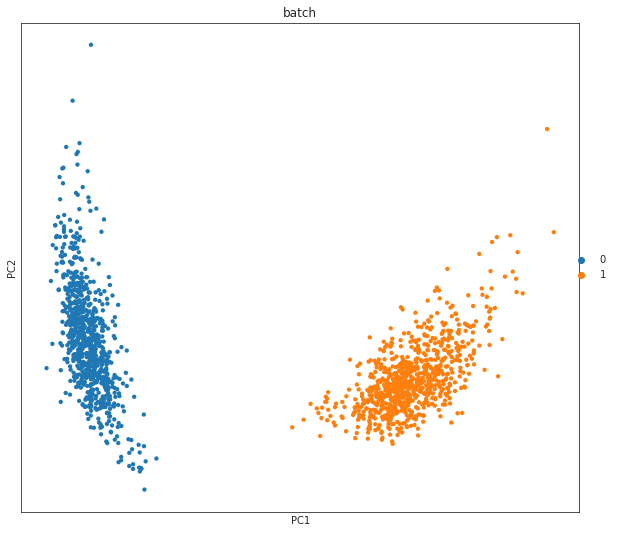

0.0

In [23]:
score_batch_corr([SENS03_B1, SENS03_B2], N_NEIGHBORS)

# Correct Data With Scanorama

Found 33694 genes among all datasets
[[ 0.    0.91]
 [ 0.    0.  ]]
Processing datasets (0, 1)


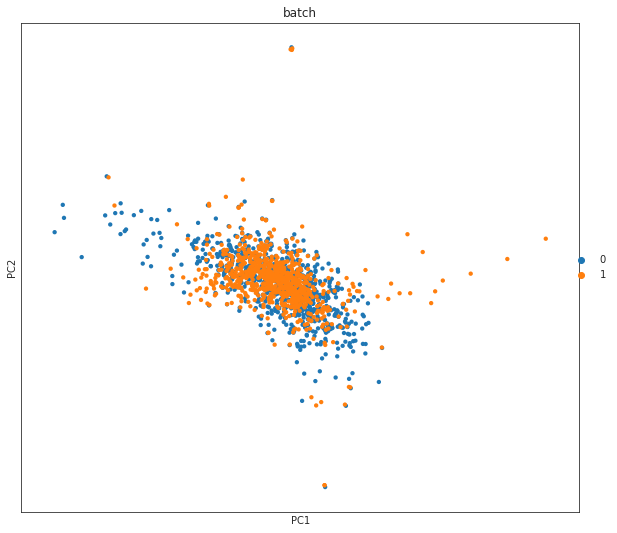

0.89149999999999996

In [24]:
SENS03_B1, SENS03_B2 = scanorama.correct_scanpy([SENS03_B1, SENS03_B2])
score_batch_corr([SENS03_B1, SENS03_B2], N_NEIGHBORS)